In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import numpy as np
import sys
import time
import shutil
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from lenet import LeNet
sys.path.pop()
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
from training import train_epoch, evaluate
sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Qut Fish Dataset

In [3]:
data_path = "C:\\Users\\hansm\\Github\\CIS472-CourseProject\\Project Datasets\\Dataset1\\QutFishDataset\\archive\\Fish_data"

In [4]:
# get all classes for the dataset
classes = []
classes_file = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset1\QutFishDataset\archive\Fish_data\final_all_index.txt"
with open(classes_file) as classesf:
    for line in classesf:
        splitted_line = line.strip().split('=')
        cls = splitted_line[1]
        if cls not in classes:
            classes.append(cls)
        else:
            continue
    classesf.close()
num_classes = len(classes)
print(num_classes)

483


In [5]:
class QutFishDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.labels = []
        self.images = []
        index_file = f"{self.data_path}\\final_all_index.txt"
        with open(index_file) as indexf:
            for line in indexf:
                splitted_line = line.strip().split('=')
                label = splitted_line[0]
                image = splitted_line[4] + ".png"
                self.labels.append(label)
                self.images.append(image)
            indexf.close()
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = Image.open(f"{self.data_path}\\images\\numbered\\{self.images[idx]}").convert("RGB")
        img = self.transform(img)
        label = torch.tensor(int(self.labels[idx]) - 1)
        return img, label

**Lenet Training for QUT Fish Dataset**

In [6]:
lenet = LeNet(num_classes)
lenetModel = lenet.to(device)
print(lenetModel)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=483, bias=True)
)


In [7]:
# hyperparameters
batch_size = 15
learning_rate=0.001
nepochs = 30

In [8]:
# transform
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
# Split dataset into train and test sets
fish_data = QutFishDataset(data_path=data_path, transform=transform)
train_size = int(0.8 * len(fish_data))
test_size = len(fish_data) - train_size
train_dataset, test_dataset = random_split(fish_data, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

3528
883


In [10]:
# train and test loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))

236


Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([15, 3, 32, 32]), torch.Size([15])
Labels: tensor([141, 386, 176, 364, 277, 335,  85, 166, 286, 195, 140, 100, 377, 283,
         64])



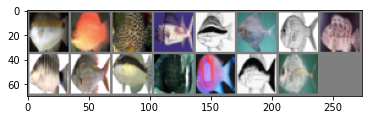

In [11]:
data = iter(train_loader) # iterate through data
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
img_grid = make_grid(single_point[0])
matplotlib_imshow(img_grid)

In [12]:
# Adam optimizer
optimizer = optim.Adam(lenetModel.parameters(), lr=learning_rate)

# loss function
LossFunction = nn.CrossEntropyLoss()

for epoch in range(nepochs):
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        output = lenetModel(inputs)
        loss = LossFunction(output, labels)
        loss.backward()
        optimizer.step()
        
        end_time = time.time()
        elapsed_time = (end_time - start_time)/60
        running_loss += loss.item()
        if (i+1) % 20 == 0:
            print('[epoch: %d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
            print(f"Time: {elapsed_time} min")
            running_loss = 0.0
    print()

print("Lenet Finished Training for QUT Fish Dataset")

[epoch: 1,    20] loss: 6.180
Time: 0.02258536418279012 min
[epoch: 1,    40] loss: 6.184
Time: 0.04653499921162923 min
[epoch: 1,    60] loss: 6.161
Time: 0.06950604518254598 min
[epoch: 1,    80] loss: 6.153
Time: 0.09658196767171225 min
[epoch: 1,   100] loss: 6.137
Time: 0.13259252309799194 min
[epoch: 1,   120] loss: 6.116
Time: 0.15681018431981406 min
[epoch: 1,   140] loss: 6.049
Time: 0.1870254397392273 min
[epoch: 1,   160] loss: 6.074
Time: 0.21106768051783245 min
[epoch: 1,   180] loss: 6.006
Time: 0.23684093952178956 min
[epoch: 1,   200] loss: 6.023
Time: 0.2640456239382426 min
[epoch: 1,   220] loss: 5.995
Time: 0.29465755621592205 min

[epoch: 2,    20] loss: 5.701
Time: 0.02957897981007894 min
[epoch: 2,    40] loss: 5.814
Time: 0.05962587197621663 min
[epoch: 2,    60] loss: 5.683
Time: 0.08774343729019166 min
[epoch: 2,    80] loss: 5.586
Time: 0.11388696829477946 min
[epoch: 2,   100] loss: 5.531
Time: 0.14180144866307576 min
[epoch: 2,   120] loss: 5.548
Time: 0.170

[epoch: 13,   120] loss: 1.765
Time: 0.21168985366821289 min
[epoch: 13,   140] loss: 1.993
Time: 0.2495370308558146 min
[epoch: 13,   160] loss: 2.036
Time: 0.2803255279858907 min
[epoch: 13,   180] loss: 1.830
Time: 0.3160073161125183 min
[epoch: 13,   200] loss: 1.793
Time: 0.3578661561012268 min
[epoch: 13,   220] loss: 1.853
Time: 0.397503916422526 min

[epoch: 14,    20] loss: 1.378
Time: 0.035388195514678956 min
[epoch: 14,    40] loss: 1.446
Time: 0.078163214524587 min
[epoch: 14,    60] loss: 1.358
Time: 0.12242408990859985 min
[epoch: 14,    80] loss: 1.571
Time: 0.1620868722597758 min
[epoch: 14,   100] loss: 1.542
Time: 0.20578163464864094 min
[epoch: 14,   120] loss: 1.586
Time: 0.2501527508099874 min
[epoch: 14,   140] loss: 1.559
Time: 0.2918979525566101 min
[epoch: 14,   160] loss: 1.647
Time: 0.3328629652659098 min
[epoch: 14,   180] loss: 1.744
Time: 0.3791584809621175 min
[epoch: 14,   200] loss: 1.685
Time: 0.4242616573969523 min
[epoch: 14,   220] loss: 1.650
Time:

[epoch: 25,   200] loss: 0.477
Time: 0.4369619886080424 min
[epoch: 25,   220] loss: 0.600
Time: 0.48025882641474404 min

[epoch: 26,    20] loss: 0.422
Time: 0.04256956577301026 min
[epoch: 26,    40] loss: 0.321
Time: 0.08549728790918985 min
[epoch: 26,    60] loss: 0.373
Time: 0.12852651278177898 min
[epoch: 26,    80] loss: 0.392
Time: 0.17210462888081868 min
[epoch: 26,   100] loss: 0.331
Time: 0.21382446686426798 min
[epoch: 26,   120] loss: 0.330
Time: 0.25364680687586466 min
[epoch: 26,   140] loss: 0.370
Time: 0.29710749387741087 min
[epoch: 26,   160] loss: 0.381
Time: 0.3413410305976868 min
[epoch: 26,   180] loss: 0.361
Time: 0.38208231925964353 min
[epoch: 26,   200] loss: 0.442
Time: 0.4231398304303487 min
[epoch: 26,   220] loss: 0.410
Time: 0.4679864684740702 min

[epoch: 27,    20] loss: 0.325
Time: 0.04564005136489868 min
[epoch: 27,    40] loss: 0.223
Time: 0.0880739450454712 min
[epoch: 27,    60] loss: 0.189
Time: 0.13016230662663777 min
[epoch: 27,    80] loss: 0.

In [13]:
lenet_accuracy = evaluate(lenetModel, test_loader)
print(f"Total accuracy for leNet for QUT Fish Dataset = {100 * lenet_accuracy / len(test_dataset):.2f}%")

Total accuracy for leNet for QUT Fish Dataset = 25.82%
